# 03_Modeling

https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

## Imports

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import average_precision_score, adjusted_rand_score, roc_auc_score, average_precision_score, silhouette_score
import hdbscan
import umap
import joblib  
from visualization import compare_hdbscan_params,compare_hdbscan_params_fast, plot_metrics_comparison, compute_mahalanobis_VI
import plotly.express as px

## Load data

In [33]:
df = pd.read_csv('../data/preprocessed_datasets/windowed_dataset_cleaned.csv')
X = df[df.columns.difference(['is_attack'])]  # Features
y = df['is_attack']  # Labels

## HDBSCAN

### Selecting hyperparameters

Escalando datos...


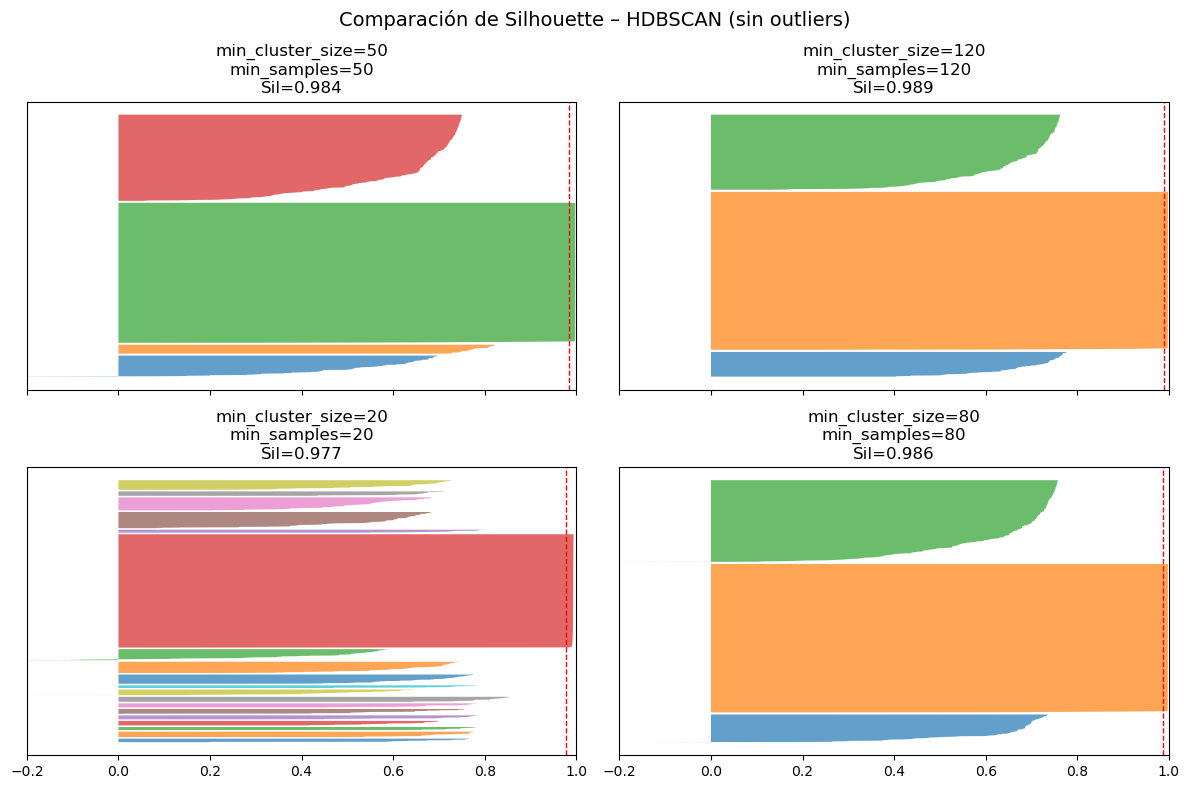

In [34]:
param_grid = [
    (50, 50),
    (120, 120),
    (20, 20),
    (80, 80),
]

results, fig1 = compare_hdbscan_params(
    X, 
    param_grid,
    y_true=y,
    n_cols=2
)

plt.show()

- The main 2 parameters in HDBSCAN are **min_cluster_size** and **min_samples**. There are also parametros like **alpha**, but it is considered better not to mess around with this parameter. With these 2 parameters we can influence the number and size of the clusters. 
- **min_cluster_size** is the minimum number of points a cluster needs to be considered a cluster. We know our data and do not want many small clusters, so we will keep it higher than 50. **min_samples** tells how conservative the model is going to be. The more conservative it is, the more samples is going to cluster as outliers.
- **min_cluster_size = min_samples** is the way to go for outlier detection with HDBSCAN as we make dense clusters only and the rest are considered outliers.

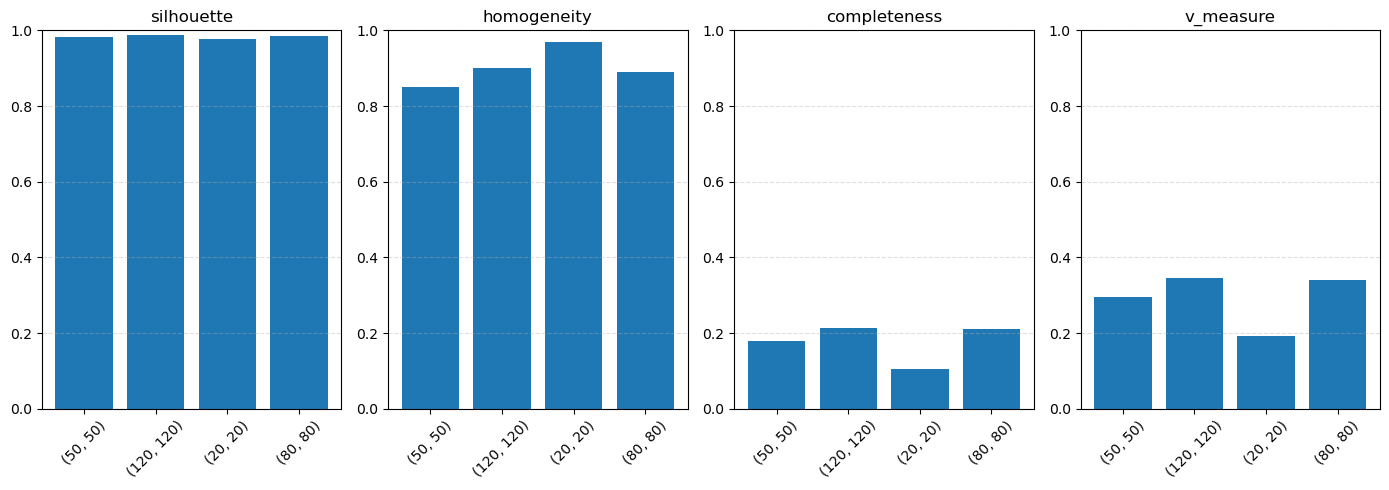

In [35]:
fig2 = plot_metrics_comparison(results)
plt.show()

- When selecting the best hyperparameteres, we look for the ones that make correct clustering. If we look at the Silhouette visuals, we don't want a clustering split which has samples with negative Silhouette scores. that would mean that some samples are closer to the closest cluster that to their own one.
- Semi supervised approach: We also look for the ones that have the classes correctly distributed between clusters. Ideally every sample of the same class should be in the same cluster (completeness) and no sample of the other classes should be sharing that same cluster (homogeneity).
- Here, **min_cluster_size = min_samples = 120** matches every requirement

### Fitting the model

In [36]:
# -----------------------------
# HDBSCAN clustering
# -----------------------------
from sklearn.pipeline import Pipeline

hdb = Pipeline([
    ('scaler', RobustScaler()),  # Escala a media=0, std=1
    ('hdb', hdbscan.HDBSCAN(
        min_cluster_size=120,#Se recomienda igualar min_samples a min_cluster_size para outlier detection
        min_samples=120, # bajarlo significa tomar mas riesgo y clusterizar mas puntos, subirlo significa ser mas conservador y detectar mas outliers
        cluster_selection_method='eom', # 'leaf' or 'eom' EXCESS of Mass para clusters más grandes y estables
        metric='euclidean',
    ))
])

hdb_labels = hdb.fit_predict(X)
print("HDBSCAN clusters:", np.unique(hdb_labels))

HDBSCAN clusters: [-1  0  1  2]


The model has made 3 clusters and outliers

### Visualizing the results: PCA & UMAP

In [37]:
pca_pipeline = Pipeline([
    ('scaler',RobustScaler()),
    ('pca',PCA(n_components=2, random_state=42))
])
X_pca = pca_pipeline.fit_transform(X)

print("Varianza explicada por componente:")
print(pca_pipeline.__getitem__("pca").explained_variance_ratio_)
print("Varianza total explicada:", pca_pipeline.__getitem__("pca").explained_variance_ratio_.sum())

df_pca = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'HDBSCAN_cluster': hdb_labels.astype(str),
    'is_attack': y
})

fig = px.scatter(
    df_pca,
    x='PCA1',
    y='PCA2',
    color='HDBSCAN_cluster',
    title="PCA (2D) – HDBSCAN clusters",
    width=900,
    hover_data=['is_attack'],
    height=700
)

fig.update_traces(marker=dict(size=6, opacity=0.8))
fig.update_layout(legend_title_text='HDBSCAN Cluster')

fig.show()


Varianza explicada por componente:
[0.55767164 0.43215248]
Varianza total explicada: 0.9898241214491248


The clusters are spatially mixed rather than cleanly separated, indicating **overlapping** or low-discrimination features in the reduced space. (2D)

In [38]:
# -----------------------------
# UMAP embedding
# -----------------------------
umap_pipeline = Pipeline([
    ('scaler',RobustScaler()),
    ('umap',
        umap.UMAP(
        n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        random_state=42
    ))
])

X_umap = umap_pipeline.fit_transform(X)

df_vis = df.copy()
df_vis['UMAP1'] = X_umap[:, 0]
df_vis['UMAP2'] = X_umap[:, 1]
df_vis['cluster_label'] = hdb_labels

df_vis['Cluster'] = df_vis['cluster_label'].map(
    lambda lbl: 'Outlier' if lbl == -1 else f'Cluster {lbl}'
)

cluster_order = ['Outlier'] + [f'Cluster {i}' for i in sorted(df_vis[df_vis['cluster_label'] != -1]['cluster_label'].unique())]
df_vis['Cluster'] = pd.Categorical(df_vis['Cluster'], categories=cluster_order, ordered=True)

hover_cols = ['is_attack', 'n_connections'] 

fig = px.scatter(
    df_vis,
    x='UMAP1',
    y='UMAP2',
    color='Cluster',
    hover_data=hover_cols,  # Ahora sí: columnas del DataFrame
    title="UMAP + HDBSCAN clusters",
    width=900,
    height=700
)

fig.update_traces(marker=dict(size=6, opacity=0.8))
fig.update_layout(legend_title_text='HDBSCAN Clusters')
fig.write_image(
    "../reports/figures/umap_hdbscan_210.png",
    width=1000,      # ancho en píxeles
    height=600,      # alto en píxeles
    scale=2          # factor de escalado (2 = ~200 DPI)
)
fig.show()

/Users/taxi/miniconda3/envs/consoning/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Users/taxi/miniconda3/envs/consoning/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:324: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



- The model sees a big central cluster and 3 smaller islands that look like curves.
- As the attacks are very close to some network traffic instances the model mixes them together in the cluster 0 and outliers. (zoom bottom right corner). The HDBSCAN algorithm is based on densities. The samples in the bottom right corner are very close to eachother so that might complicate the task of clustering via densities. Making the difference for the model becomes a very difficult task.
- The model also sees some outliers in the top small islands.

In [59]:
pd.crosstab(df['is_attack'], hdb_labels)

col_0,-1,0,1,2
is_attack,,,,
0,1195,26,22057,381
1,246,100,0,0


- The outlier management is better than with GMM but the model is not able to isolate every attack as outlier or as a cluster.
- A dedicated model for outlir detection should be used for this type of problem.

Let's see what type of traffic is the model having difficulties to isolate the attacks from. (Cluster -1,0)

## Analyze via cluster inspection

In [64]:
# Focus ONLY on clusters -1 and 0
df_focus = df_vis[df_vis['Cluster'].isin(['Outlier', 'Cluster 0'])].copy()

# Define groups
c0_legit = df_focus[
    (df_focus['Cluster'] == 'Cluster 0') &
    (df_focus['is_attack'] == 0)
]

c0_attack = df_focus[
    (df_focus['Cluster'] == 'Cluster 0') &
    (df_focus['is_attack'] == 1)
]

cminus1_legit = df_focus[
    (df_focus['Cluster'] == 'Outlier') &
    (df_focus['is_attack'] == 0)
]

cminus1_attack = df_focus[
    (df_focus['Cluster'] == 'Outlier') &
    (df_focus['is_attack'] == 1)
]


# Transparency
print(f"Cluster 0 - Legitimate:   {len(c0_legit):>6}")
print(f"Cluster 0 - Attack:   {len(c0_attack):>6}")
print(f"Outlier - Legitimate: {len(cminus1_legit):>6}")
print(f"Outlier - Attack:     {len(cminus1_attack):>6}")
print("="*80)

features = [
    'burst_score_max',
    'conn_count_10s_max',
    'conn_count_60s_max',
    'ja3_frequency_mean',
    'recent_activity_score_std',
    'n_connections',
    'bytes_ratio_mean'
]

comparison_data = []
for feature in features:
    comparison_data.append({
        'Feature': feature,
        'C0_Legit': c0_legit[feature].mean(),
        'C0_Attack': c0_attack[feature].mean(),

        'Outlier_Legit': cminus1_legit[feature].mean(),
        'Outlier_Attack': cminus1_attack[feature].mean()
    })

comparison_df = pd.DataFrame(comparison_data)

print("\nCENTRAL TENDENCY (MEAN)")
print("="*80)
print(comparison_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

std_data = []
for feature in features:
    std_data.append({
        'Feature': feature,
        'C0_Legit': c0_legit[feature].std(),
        'C0_Attack': c0_attack[feature].mean(),

        'Outlier_Legit': cminus1_legit[feature].std(),
        'Outlier_Attack': cminus1_attack[feature].std()
    })

std_df = pd.DataFrame(std_data)

print("\nVARIABILITY (STD)")
print("="*80)
print(std_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
print("="*80)


Cluster 0 - Legitimate:       26
Cluster 0 - Attack:      100
Outlier - Legitimate:   1195
Outlier - Attack:        246

CENTRAL TENDENCY (MEAN)
                  Feature  C0_Legit  C0_Attack  Outlier_Legit  Outlier_Attack
          burst_score_max    0.9231     0.9900         0.1481          0.9797
       conn_count_10s_max    2.0385     6.7300         1.9632          7.3333
       conn_count_60s_max    2.7692     6.7300         2.5347          7.4472
       ja3_frequency_mean   72.1538   385.3500        69.0544        396.1829
recent_activity_score_std    0.0777     0.2819         0.0706          0.2682
            n_connections    1.7692     6.3700         2.0276          6.8293
         bytes_ratio_mean    0.3326     0.2325         0.5088          0.2167

VARIABILITY (STD)
                  Feature  C0_Legit  C0_Attack  Outlier_Legit  Outlier_Attack
          burst_score_max    0.2717     0.9900         0.3554          0.1414
       conn_count_10s_max    0.5277     6.7300         0

In [69]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Features más discriminantes
discriminant_features = [
    'ja3_frequency_mean',
    'conn_count_10s_max',
    'burst_score_max',
    'bytes_ratio_mean',
    'recent_activity_score_std',
    
]

def format_value(v):
    if pd.isna(v):
        return "NaN"
    elif abs(v) >= 1e-3:
        return f"{v:.4f}"
    else:
        return f"{v:.2e}"

fig_bars = make_subplots(
    rows=2, cols=3,
    subplot_titles=[f.replace('_', ' ').title() for f in discriminant_features],
    vertical_spacing=0.12,
    horizontal_spacing=0.10
)

# NUEVOS grupos coherentes con HDBSCAN
group_names = [
    'C0_Legit',
    'C0_Attack',
    'Outlier_Legit',
    'Outlier_Attack',
]

colors = ['#2ecc71','#3498db', '#f39c12', '#e74c3c']

for idx, feature in enumerate(discriminant_features):
    row = idx // 3 + 1
    col = idx % 3 + 1
    
    values = [
        comparison_df.loc[comparison_df['Feature'] == feature, 'C0_Legit'].values[0],
        comparison_df.loc[comparison_df['Feature'] == feature, 'C0_Attack'].values[0],
        comparison_df.loc[comparison_df['Feature'] == feature, 'Outlier_Legit'].values[0],

        comparison_df.loc[comparison_df['Feature'] == feature, 'Outlier_Attack'].values[0],
    ]
    
    max_val = max([v for v in values if not pd.isna(v)], default=0)
    y_max = max(0.001, max_val * 1.25)
    fig_bars.update_yaxes(range=[0, y_max], row=row, col=col)
    
    for group, value, color in zip(group_names, values, colors):
        fig_bars.add_trace(
            go.Bar(
                x=[group],
                y=[value],
                name=group if idx == 0 else None,
                marker_color=color,
                text=[format_value(value)],
                textposition='outside',
                textfont=dict(size=10),
                showlegend=(idx == 0),
                hovertemplate=(
                    f'<b>{group}</b><br>'
                    f'{feature}: %{{y:.6f}}<extra></extra>'
                )
            ),
            row=row, col=col
        )

fig_bars.update_yaxes(title_text="Mean value", col=1)
fig_bars.update_layout(
    title_text='Key Features: Cluster 0 vs Outliers (Legit vs Attack)',
    title_font_size=16,
    height=650,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="center",
        x=0.5
    ),
    plot_bgcolor='white',
    paper_bgcolor='#f8f9fa'
)

fig_bars.show()


Outliers and Cluster 0:

- The attacking samples, have a higher **burst_score (0.9797 and 0.9900)**, **conn_count_10s(7.3333 and 6.7300)** and **conn_count_60s(7.4472 and 6.7300)**. As expected, the attacks include more connections and in shorter periods of time. This happens because the attacker has to fetch many endpoints in Consul to scan the services.
- The **ja3_frequency_mean** is significantly lower compared to Legit Outliers. Since our services use HttpxClient to query Consul, the TLS handshake is reused within persistent connections. This results in fewer unique JA3 fingerprints per time window, as there are not many new connections being established.
- The Legitimate ouliers, still show higher intensity in connections than the normal requests or periodic healthcheck that we mentioned in `03a_modeling_gmm.ipynb`. 
- The Attack also have smaller **bytes_ratio_mean** which means that in their connections, the size of the response payloads are heavier than the request ones. This pattern matches the idea of scanning the endpoints of Consul by doing: (https://consul_ip/v1/catalog/services). The response payload size of this GET will be much heavier than (GET https://consul_ip/v1/catalog/service/order). 
- Finally, everything suggests that the legitimate samples of the 0th Cluster and of the Outliers are PUT (self-registries) or instense connections like healthchecks when a service switches to down or up.


## Save model

In [41]:
joblib.dump(hdb, "../models/hdbscan_model.joblib")

['../models/hdbscan_model.joblib']